# Example: Center of Mass calculation

Prerequisites: 

 * a python3.6 or python3.7 virtualenv with all requirements installed
  * LiberTEM 0.2.0.dev0 or newer -- see [installation instructions from source](https://libertem.github.io/LiberTEM/install.html#installing-from-a-git-clone)
  * ``pip install hyperspy hyperspy_gui_ipywidgets notebook`` for additional dependencies
 * a HDF5 dataset

We disable threading in OpenBLAS because it would interfere with the dask multiprocessing and because OpenBLAS likes to call ``sched_yield`` for no discernable reason

In [1]:
%env OMP_NUM_THREADS=1
%env OPENBLAS_NUM_THREADS=1
%env OPENBLAS_NUM_THREADS=1

env: OMP_NUM_THREADS=1
env: OPENBLAS_NUM_THREADS=1
env: OPENBLAS_NUM_THREADS=1


In [2]:
%matplotlib nbagg

Import our dependencies. There may be some warnings about ``hyperspy_gui_traitui`` and so on which can be safely ignored (you do need ``hyperspy_gui_ipywidgets`` though):

In [3]:
from scipy.ndimage import measurements
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import hyperspy.api as hs

from libertem import api

This starts a local cluster that is accessible through ``ctx``. Starting several clusters in parallel is unproblematic because each cluster is rather lightweight and relies on the host file system for caching.

In [4]:
ctx = api.Context()

If you want to run this notebook, you may need to adjust the ``emd_path`` variable and ``hdf5path`` parameter here. This example uses a local HDF5 file as input dataset.

In [5]:
emd_path = 'C:/Users/weber/Nextcloud/Projects/Open Pixelated STEM framework/Data/EMPAD/scan_11_x256_y256.emd'

hdf5path = 'experimental/science_data/data'

ds = ctx.load(
    'hdf5',
    path=emd_path,
    ds_path=hdf5path,
    tileshape=(1,8,128,128)
)
(scan_y, scan_x, detector_y, detector_x) = ds.shape
mask_shape = np.array((detector_y, detector_x))

Now, we create a center of mass (COM) analysis. We set the mask radius to `None` (default) to use the entire frame.

In [6]:
cx = detector_x/2
cy = detector_y/2
analysis = ctx.create_com_analysis(dataset=ds, cx=cx, cy=cy, mask_radius=None)

We kick off the computation:

In [7]:
%time result = ctx.run(analysis)

Wall time: 21 s


Let's show the result:

In [8]:
print(result)

[<AnalysisResult: field>, <AnalysisResult: magnitude>, <AnalysisResult: divergence>, <AnalysisResult: x>, <AnalysisResult: y>]


In [9]:
print(result.field)

title: field
desc: cubehelix colorwheel visualization
key: field
raw_data: (array([[ 0.2787552 , -0.39032364,  1.1497574 , ..., -0.68854904,
        -0.80986786, -1.0292397 ],
       [ 0.30957794,  0.5550537 ,  0.95254517, ..., -0.7731705 ,
        -0.9073677 , -1.1169281 ],
       [ 0.00856018,  0.21022797,  0.9546356 , ..., -1.0613785 ,
        -1.306221  , -1.4584236 ],
       ...,
       [ 0.31816864,  1.0073853 ,  0.48000336, ...,  0.15504456,
         0.02667236, -0.29509735],
       [ 0.6370621 ,  0.6483917 , -0.16072464, ..., -0.05503082,
         0.01832581, -0.28866577],
       [ 0.46069336,  0.48744202, -0.5629654 , ..., -0.29447556,
         0.23344421,  0.24785614]], dtype=float32), array([[-0.80867386, -0.9032135 , -0.7465744 , ..., -0.8712654 ,
        -0.50823975, -0.19401932],
       [-0.5821953 , -0.7735901 , -1.3177528 , ..., -1.5244675 ,
        -0.8678589 , -0.57385254],
       [-0.6904297 , -0.92946243, -0.8849373 , ..., -1.9639473 ,
        -1.4774971 , -0.931449

We show the default visualization for field and for magnitude.

<IPython.core.display.Javascript object>


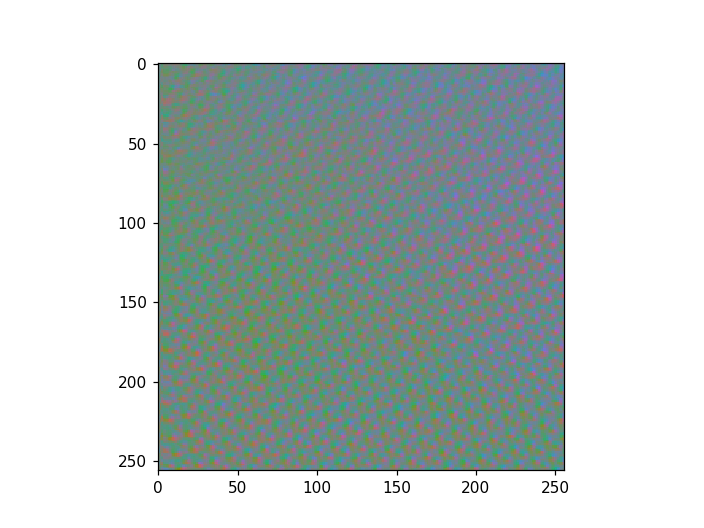

<IPython.core.display.Javascript object>


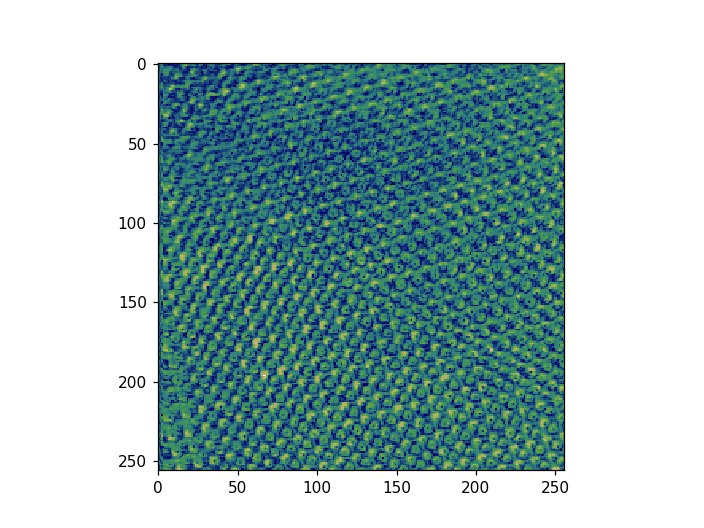

In [10]:
fig, axes = plt.subplots()
axes.imshow(result.field.visualized)
fig, axes = plt.subplots()
axes.imshow(result.magnitude.visualized)

Let's create a HyperSpy signal that contains the `(x, y)` pairs as signal for each scan position:

<IPython.core.display.Javascript object>


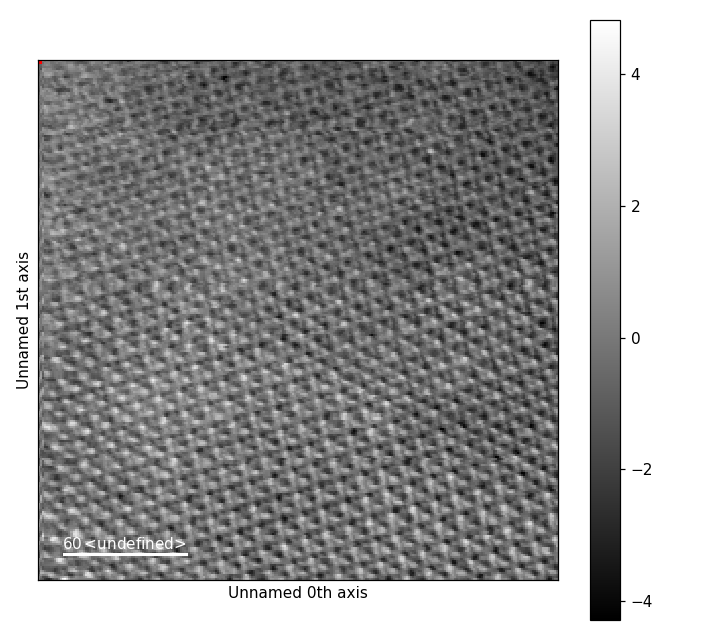

<IPython.core.display.Javascript object>


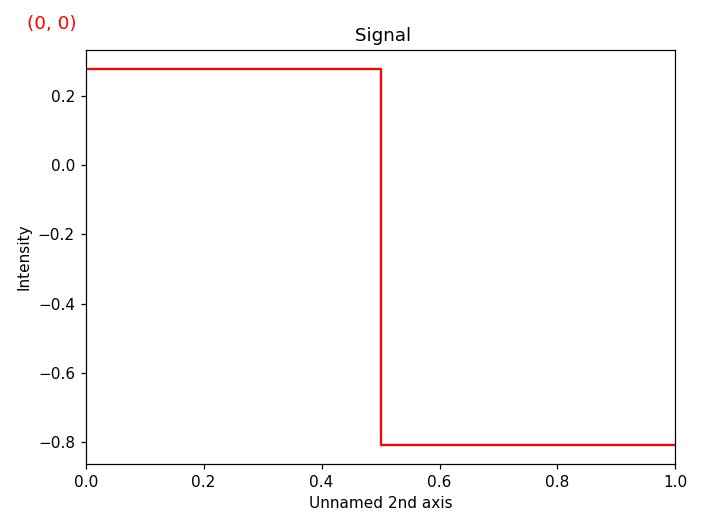

In [11]:
centers = hs.signals.Signal1D(np.dstack((result.x.raw_data, result.y.raw_data)))
centers.plot()

Ok, now that we have our results, let's see how we compare to the ``scipy`` implementation. Let's use HyperSpy to load the dataset lazily (``optimize=False`` because of the lazy signal):

In [12]:
raw_data = hs.load(emd_path, lazy=True).as_signal2D(image_axes=(0, 1), optimize=False)

Let's have a look at one frame, plot it and see how the result compares to ours. We add `cx` resp. `cy` to our coordinates because we've set these as reference center for our center of mass calculation.

<IPython.core.display.Javascript object>


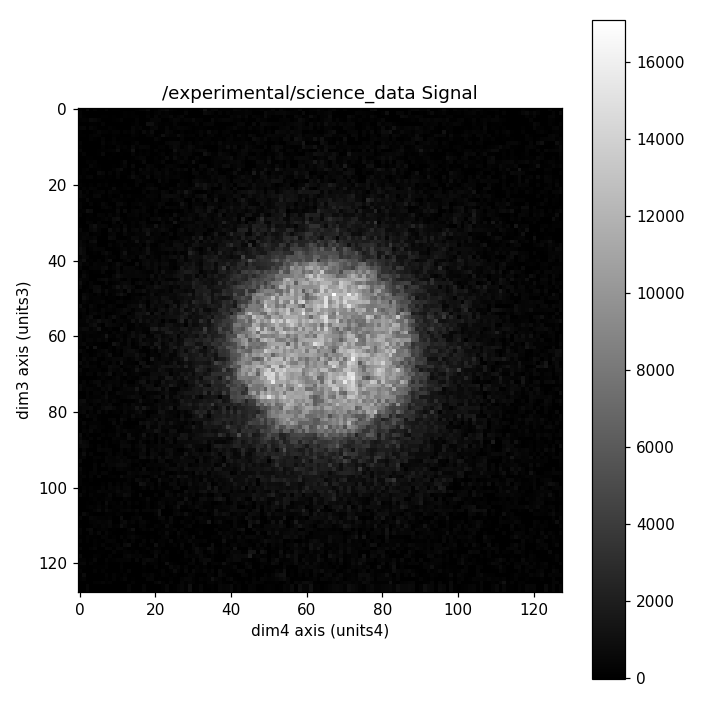

scipy center: x=64.278758, y=63.191338
our center:   x=64.278755, y=63.191326
difference from scipy: x=0.000003, y=0.000012


In [13]:
frame_coords = (0, 0)
frame = raw_data.inav[frame_coords]
frame.plot(navigator=None)
frame_data = frame.data.compute()
center_y, center_x = measurements.center_of_mass(frame_data)


# marker = hs.plot.markers.point(x=center_x, y=center_y, color='red')
# frame.add_marker(marker) # -> crashes for some reason


print("scipy center: x=%.6f, y=%.6f" % (center_x, center_y))
print("our center:   x=%.6f, y=%.6f" % (centers.inav[frame_coords].isig[0].data[0] + cx,
                                      centers.inav[frame_coords].isig[1].data[0] + cy))
print("difference from scipy: x=%.6f, y=%.6f" % (
    (center_x - centers.inav[frame_coords].isig[0].data[0] - cx),
    (center_y - centers.inav[frame_coords].isig[1].data[0] - cy)
))